In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Define the dataset path (adjust the path based on your Kaggle dataset configuration)
data_dir = "/kaggle/input/images-of-mechanical-parts-boltnut-washerpin/blnw-images-224"

# Define transforms: data augmentation for training and basic normalization for validation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
print("Classes found:", full_dataset.classes)

# Split the dataset into training and validation sets (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# For validation, use validation transforms
# (Note: one can override the transform for the val_dataset)
val_dataset.dataset.transform = val_transforms

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Classes found: ['bolt', 'locatingpin', 'nut', 'washer']
Training samples: 6092, Validation samples: 1524


In [4]:
# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze early layers (optional – fine tune only the last layers)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
num_features = model.fc.in_features
num_classes = len(full_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)

# Unfreeze the final layer (or more layers if fine-tuning is desired)
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
num_epochs = 5  # Increase this number based on your requirements

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/5 - Loss: 0.4366, Val Accuracy: 0.9140
Epoch 2/5 - Loss: 0.2705, Val Accuracy: 0.9035
Epoch 3/5 - Loss: 0.2048, Val Accuracy: 0.9324
Epoch 4/5 - Loss: 0.1814, Val Accuracy: 0.9547
Epoch 5/5 - Loss: 0.1647, Val Accuracy: 0.9606


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


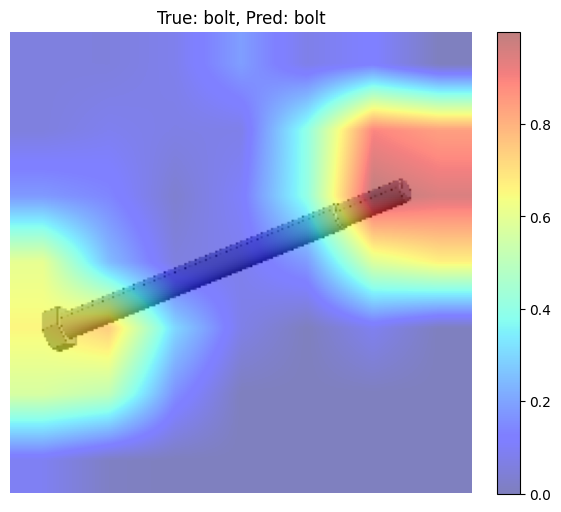

In [9]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        # Hook to capture the forward activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Hook to capture the backward gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        # Use register_backward_hook to avoid conflict with full backward hooks
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.append(handle_forward)
        self.hook_handles.append(handle_backward)

    def __call__(self, input_tensor, class_idx=None):
        # Ensure the input requires gradients for backward propagation
        input_tensor.requires_grad = True

        # Forward pass
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass for the target class score
        target = output[0, class_idx]
        target.backward()

        # Compute weights via global-average-pooling of the gradients
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)

        # Compute Grad-CAM: weighted sum of forward activations and apply ReLU
        grad_cam_map = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        grad_cam_map = torch.nn.functional.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()

        # Normalize the heatmap between 0 and 1
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map

# Example usage:
# Select the target layer for Grad-CAM; for ResNet50, we use the last block of layer4.
target_layer = model.layer4[-1]
grad_cam = GradCAM(model, target_layer)

# Get a sample image from the validation dataset
model.eval()
sample_img, label = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

# Ensure input tensor has gradients enabled (this is crucial for the backward pass)
input_tensor.requires_grad = True

# Get the model prediction and corresponding class index
output = model(input_tensor)
pred_label = output.argmax(dim=1).item()

# Compute the Grad-CAM heatmap for the predicted class
heatmap = grad_cam(input_tensor, class_idx=pred_label)

# Visualize the results
def imshow(img, title=None):
    """Display an image tensor after undoing normalization."""
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(8, 6))
imshow(sample_img, title=f"True: {full_dataset.classes[label]}, Pred: {full_dataset.classes[pred_label]}")
plt.imshow(heatmap, cmap='jet', alpha=0.5, extent=(0, 224, 224, 0))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

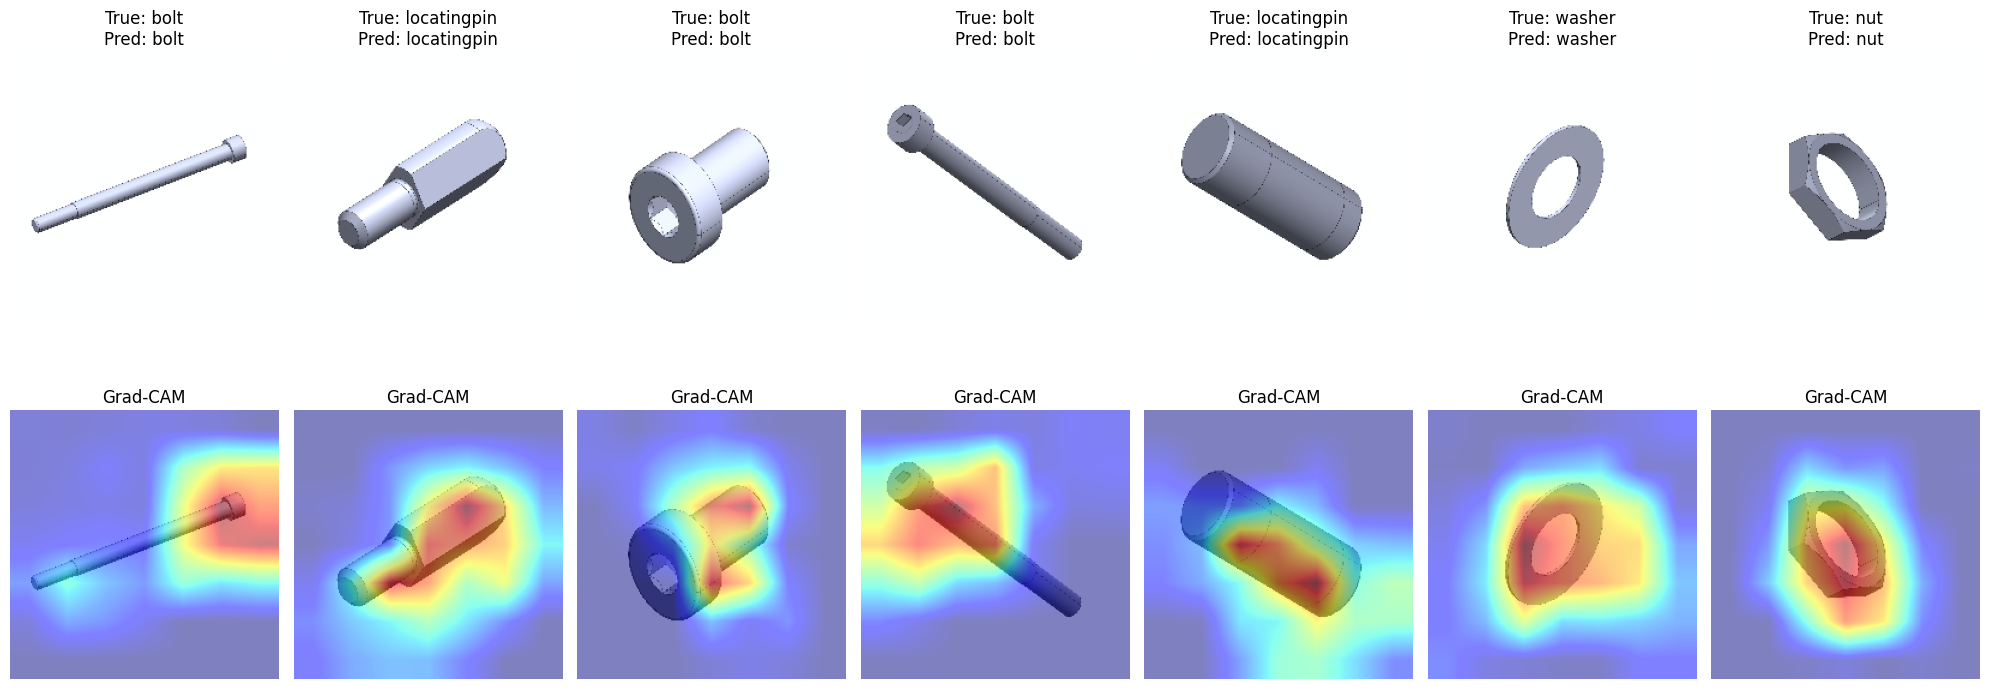

In [15]:
import random

# Number of samples to display
num_samples = 7

# Randomly select indices from the validation dataset
sample_indices = random.sample(range(len(val_dataset)), num_samples)

plt.figure(figsize=(20, 8))

for i, idx in enumerate(sample_indices):
    sample_img, true_label = val_dataset[idx]
    input_tensor = sample_img.unsqueeze(0).to(device)
    input_tensor.requires_grad = True  # Ensure gradients are tracked

    # Model prediction
    output = model(input_tensor)
    pred_label = output.argmax(dim=1).item()

    # Compute Grad-CAM heatmap for the predicted class
    heatmap = grad_cam(input_tensor, class_idx=pred_label)

    # Display original image with prediction labels (undo normalization in imshow)
    plt.subplot(2, num_samples, i+1)
    imshow(sample_img, title=f"True: {full_dataset.classes[true_label]}\nPred: {full_dataset.classes[pred_label]}")
    
    # Display image with heatmap overlay
    plt.subplot(2, num_samples, num_samples + i+1)
    imshow(sample_img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5, extent=(0, 224, 224, 0))
    plt.title("Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Define the path where the model will be saved
model_save_path = "resnet50_gradcam_model.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

Model saved to resnet50_gradcam_model.pth


In [17]:
import os
from torchvision import datasets, transforms

# Set the dataset directory (update the path if necessary)
data_dir = "/kaggle/input/images-of-mechanical-parts-boltnut-washerpin/blnw-images-224"

# Define a simple transform (not critical if only extracting class names)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create an ImageFolder dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Print the list of classes
print("Classes found:", dataset.classes)

Classes found: ['bolt', 'locatingpin', 'nut', 'washer']
